In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))
from os.path import expanduser

%load_ext autoreload
%autoreload 2

from dotenv import load_dotenv
load_dotenv()

from google.cloud import storage
from project_config import GCP_PROJECT_NAME, DATASET_JSON_PATH

gcp_client = storage.Client(project=GCP_PROJECT_NAME)

2023-12-27 16:29:40:rastervision.pipeline.rv_config: WARNING - Root temporary directory cannot be used: /data/tmp. Using root: /data/tmp/tmpfd1vv4sc


In [2]:
import os, torch
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:32" #to prevent cuda out of memory error
torch.cuda.empty_cache()


#For reproducibility
torch.manual_seed(13)



### Configuration

In [3]:
from experiment_configs.configs import *
config = satmae_large_config


### Create Rastervision datasets

In [4]:
from torch.utils.data import ConcatDataset
import json
from utils.rastervision_pipeline import observation_to_scene, scene_to_training_ds, scene_to_validation_ds, scene_to_inference_ds
from utils.data_management import observation_factory, characterize_dataset
import random

#set the seed
random.seed(13)

# get the current working directory
root_dir = os.getcwd()

# define the relative path to the dataset JSON file
json_rel_path = '../' + DATASET_JSON_PATH

# combine the root directory with the relative path
json_abs_path = os.path.join(root_dir, json_rel_path)

dataset_json = json.load(open(json_abs_path, 'r'))
all_observations = observation_factory(dataset_json)

#find the highest cluster id
max_cluster_id = max([observation['cluster_id'] for observation in dataset_json])


# Randomly split the data into training and validation
val_split = random.randint(0, max_cluster_id+1)

training_scenes = []
validation_scenes = []

for observation in all_observations:
    if observation.cluster_id == val_split: 
        validation_scenes.append(observation_to_scene(config, observation))
    else:
        training_scenes.append(observation_to_scene(config, observation))


training_datasets = [
    scene_to_training_ds(config, scene) for scene in training_scenes #random window sampling happens here
]
validation_datasets = [
    # scene_to_validation_ds(config, scene) for scene in validation_scenes
    scene_to_inference_ds(config, scene, full_image=False, stride=int(config.tile_size/2)) for scene in validation_scenes # better performance with this
]

train_dataset_merged = ConcatDataset(training_datasets)
val_dataset_merged = ConcatDataset(validation_datasets)

print('Validation split cluster_id:', val_split)
print ('Training dataset size: {:4d} images | Number of observations: {:}'.format(len(train_dataset_merged), len(training_scenes)))
print ('Testing dataset size: {:4d}  images | Number of observations: {:}'.format(len(val_dataset_merged), len(validation_scenes)))

mine_percentage_aoi = characterize_dataset(training_scenes, validation_scenes)

2023-12-27 13:28:28:rastervision.pipeline.file_system.utils: INFO - Downloading https://storage.googleapis.com/sand_mining_median/labels/Kathajodi_Cuttack_85-85_20-44_median/s2/Kathajodi_Cuttack_85-85_20-44_2022-05-01_s2.tif to /data/tmp/tmp72qf1yya/cache/http/storage.googleapis.com/sand_mining_median/labels/Kathajodi_Cuttack_85-85_20-44_median/s2/Kathajodi_Cuttack_85-85_20-44_2022-05-01_s2.tif...


2023-12-27 13:28:28:rastervision.pipeline.file_system.utils: INFO - Downloading https://storage.googleapis.com/sand_mining_median/labels/Kathajodi_Cuttack_85-85_20-44_median/annotations/Kathajodi_Cuttack_85-85_20-44_2022-05-01_annotations.geojson to /data/tmp/tmp72qf1yya/cache/http/storage.googleapis.com/sand_mining_median/labels/Kathajodi_Cuttack_85-85_20-44_median/annotations/Kathajodi_Cuttack_85-85_20-44_2022-05-01_annotations.geojson...
2023-12-27 13:28:28:rastervision.pipeline.file_system.utils: INFO - Downloading https://storage.googleapis.com/sand_mining_median/labels/Kathajodi_Cuttack_85-85_20-44_median/rivers/Kathajodi_Cuttack_85-85_20-44_rivers_1000m.geojson to /data/tmp/tmp72qf1yya/cache/http/storage.googleapis.com/sand_mining_median/labels/Kathajodi_Cuttack_85-85_20-44_median/rivers/Kathajodi_Cuttack_85-85_20-44_rivers_1000m.geojson...
2023-12-27 13:28:28:rastervision.core.data.vector_source.geojson_vector_source: INFO - Ignoring CRS ({'type': 'name', 'properties': {'name':

 77%|#######6  | 136M/177M [00:05<00:01, 27.3MB/s]

2023-12-27 13:28:39:rastervision.pipeline.file_system.utils: INFO - Downloading https://storage.googleapis.com/sand_mining_median/labels/Sone_Rohtas_84-21_24-91_median/annotations/Sone_Rohtas_84-21_24-91_2022-02-01_annotations.geojson to /data/tmp/tmp72qf1yya/cache/http/storage.googleapis.com/sand_mining_median/labels/Sone_Rohtas_84-21_24-91_median/annotations/Sone_Rohtas_84-21_24-91_2022-02-01_annotations.geojson...
2023-12-27 13:28:40:rastervision.pipeline.file_system.utils: INFO - Downloading https://storage.googleapis.com/sand_mining_median/labels/Sone_Rohtas_84-21_24-91_median/rivers/Sone_Rohtas_84-21_24-91_rivers_1000m.geojson to /data/tmp/tmp72qf1yya/cache/http/storage.googleapis.com/sand_mining_median/labels/Sone_Rohtas_84-21_24-91_median/rivers/Sone_Rohtas_84-21_24-91_rivers_1000m.geojson...
2023-12-27 13:28:40:rastervision.core.data.vector_source.geojson_vector_source: INFO - Ignoring CRS ({'type': 'name', 'properties': {'name': 'urn:ogc:def:crs:OGC:1.3:CRS84'}}) specified in

 82%|########1 | 144M/176M [00:05<00:01, 29.4MB/s]

2023-12-27 13:28:46:rastervision.pipeline.file_system.utils: INFO - Downloading https://storage.googleapis.com/sand_mining_median/labels/Sone_Rohtas_84-21_24-91_median/annotations/Sone_Rohtas_84-21_24-91_2022-05-01_annotations.geojson to /data/tmp/tmp72qf1yya/cache/http/storage.googleapis.com/sand_mining_median/labels/Sone_Rohtas_84-21_24-91_median/annotations/Sone_Rohtas_84-21_24-91_2022-05-01_annotations.geojson...
2023-12-27 13:28:46:rastervision.pipeline.file_system.utils: INFO - Using cached file /data/tmp/tmp72qf1yya/cache/http/storage.googleapis.com/sand_mining_median/labels/Sone_Rohtas_84-21_24-91_median/rivers/Sone_Rohtas_84-21_24-91_rivers_1000m.geojson.
2023-12-27 13:28:46:rastervision.core.data.vector_source.geojson_vector_source: INFO - Ignoring CRS ({'type': 'name', 'properties': {'name': 'urn:ogc:def:crs:OGC:1.3:CRS84'}}) specified in https://storage.googleapis.com/sand_mining_median/labels/Sone_Rohtas_84-21_24-91_median/rivers/Sone_Rohtas_84-21_24-91_rivers_1000m.geojso

 79%|#######8  | 104M/132M [00:05<00:01, 21.1MB/s]

2023-12-27 13:29:48:rastervision.pipeline.file_system.utils: INFO - Downloading https://storage.googleapis.com/sand_mining_median/labels/Godavari_BhadradriKothagudem_80-79_18-04_median/annotations/Godavari_BhadradriKothagudem_80-79_18-04_2022-05-01_annotations.geojson to /data/tmp/tmp72qf1yya/cache/http/storage.googleapis.com/sand_mining_median/labels/Godavari_BhadradriKothagudem_80-79_18-04_median/annotations/Godavari_BhadradriKothagudem_80-79_18-04_2022-05-01_annotations.geojson...
2023-12-27 13:29:48:rastervision.pipeline.file_system.utils: INFO - Using cached file /data/tmp/tmp72qf1yya/cache/http/storage.googleapis.com/sand_mining_median/labels/Godavari_BhadradriKothagudem_80-79_18-04_median/rivers/Godavari_BhadradriKothagudem_80-79_18-04_rivers_1000m.geojson.
2023-12-27 13:29:48:rastervision.core.data.vector_source.geojson_vector_source: INFO - Ignoring CRS ({'type': 'name', 'properties': {'name': 'urn:ogc:def:crs:OGC:1.3:CRS84'}}) specified in https://storage.googleapis.com/sand_

Validation split cluster_id: 4
Training dataset size: 3088 images | Number of observations: 72
Testing dataset size: 1456  images | Number of observations: 8
Total dataset has 2.93%  mining area.
Training dataset has 3.05%  mining area.
Validation dataset has 2.15%  mining area.
Within AOIs, total dataset has 6.72%  mining area.
Outside AOIs, total dataset has 0.06%  mining area.

The median percentage of mine in an observation is 3.26%
The median number of mine pixels in an observation is 38059

The median number pixels in an observation is 1301008


## Update the loss weights to account for the imbalanced dataset

In [5]:
# config.mine_class_loss_weight = (100 - mine_percentage_aoi) / mine_percentage_aoi
# config.mine_class_loss_weight = 1
config.mine_class_loss_weight

6.0

## Visualize the datasets




 Val Dataset


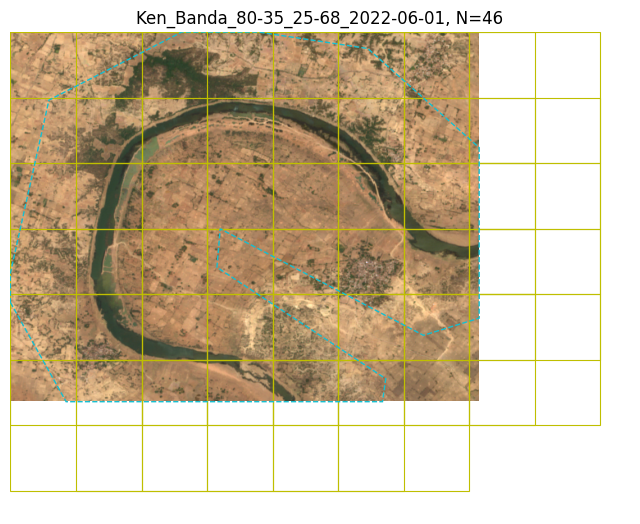

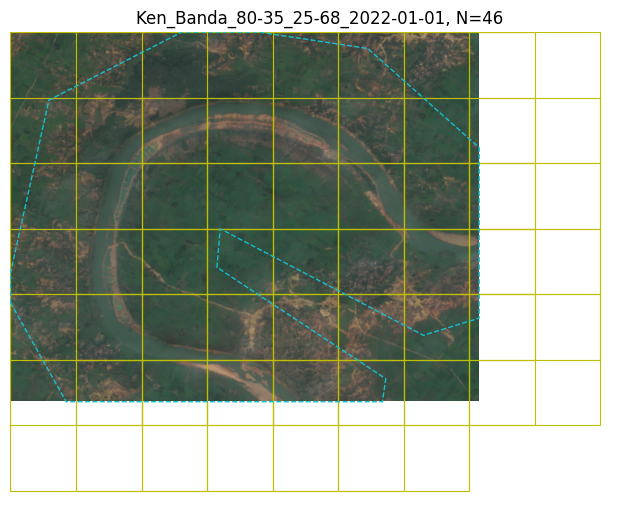

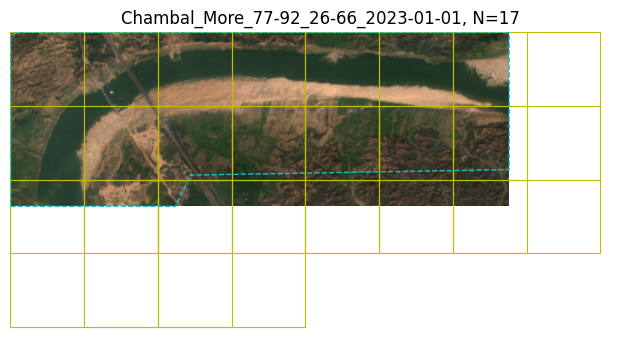

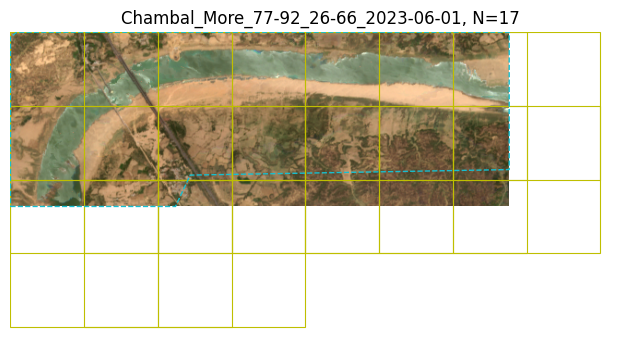

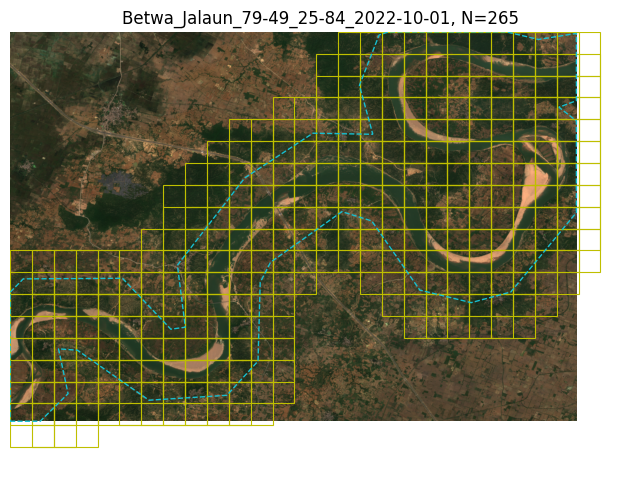

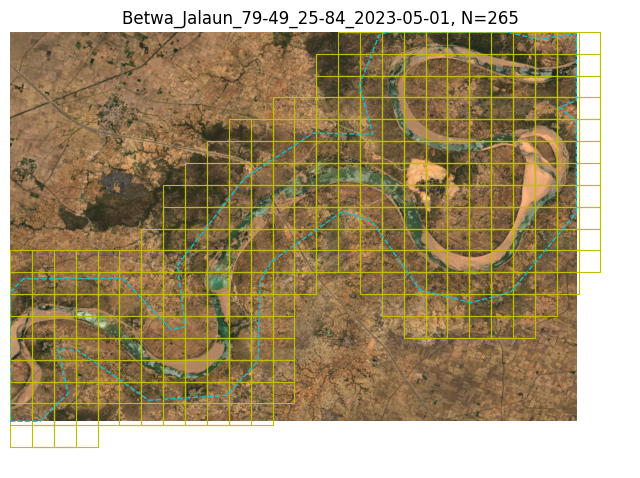

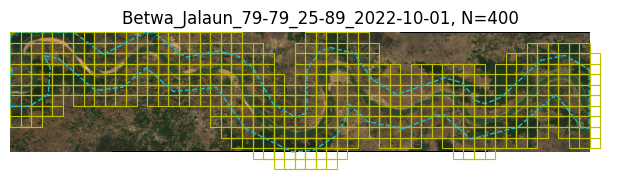

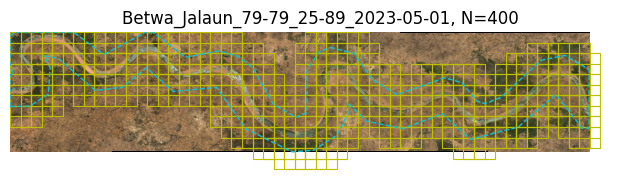

In [6]:
from utils.visualizing import visualize_dataset

# print ('Training Dataset')
# for ds in training_datasets:
#     visualize_dataset(ds)

print("\n\n\n Val Dataset")

for ds in validation_datasets:
    visualize_dataset(ds)

# Train

In [7]:
from models.model_factory import model_factory, print_trainable_parameters
from ml.optimizer_factory import optimizer_factory
from ml.learner import BinarySegmentationLearner

_, _, n_channels = training_datasets[0].scene.raster_source.shape
model = model_factory(
    config,
    n_channels=n_channels,
)

optimizer = optimizer_factory(config, model)

learner = BinarySegmentationLearner(
    config=config,
    model=model,
    optimizer=optimizer,
    train_ds=train_dataset_merged,  # for development and debugging, use training_datasets[0] or similar to speed up
    valid_ds=val_dataset_merged,  # for development and debugging, use training_datasets[1] or similar to speed up
    output_dir=expanduser("~/sandmining-watch/out/OUTPUT_DIR"),
)
print_trainable_parameters(learner.model)

SatMae: Loading encoder weights from /home/ando/sandmining-watch/out/weights/pretrain-vit-large-e199.pth
Position interpolate from 12x12 to 20x20
Warning! Missing keys:
['channel_cls_embed', 'head.weight', 'head.bias']
SatMaePretrained: Freezing encoder weights
Number of parameters loaded: 298


2023-12-27 13:30:29:rastervision: INFO - train_ds: 3088 items
2023-12-27 13:30:29:rastervision: INFO - valid_ds: 1456 items


trainable params: 7.669505M || all params: 310.951427M || trainable%: 2.47


#### Check GPU Activity

You can continuously monitor your GPU activity by using the command in the terminal


`watch -d -n 0.5 nvidia-smi`

In [8]:
# Run this cell if you want to log the run to W&B. You might need to authenticate to W&B.
learner.initialize_wandb_run()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: andoshah (sandmining-watch). Use `wandb login --relogin` to force relogin


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


In [9]:
learner.train(epochs=20)

2023-12-27 13:30:32:rastervision: INFO - epoch: 0


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validating:   0%|          | 0/15 [00:00<?, ?it/s]

2023-12-27 13:38:30:rastervision: INFO - metrics:
{'avg_f1': 0.8987182974815369,
 'avg_precision': 0.9624423980712891,
 'avg_recall': 0.8429086208343506,
 'epoch': 0,
 'other_f1': 0.9123513698577881,
 'other_precision': 0.9904837012290955,
 'other_recall': 0.8456444144248962,
 'sandmine_average_precision': 0.4680645393926235,
 'sandmine_best_f1_score': 0.4658842566865244,
 'sandmine_best_threshold': 0.8205438,
 'sandmine_f1': 0.24371197819709778,
 'sandmine_precision': 0.1450103372335434,
 'sandmine_recall': 0.7631561160087585,
 'train_bce_loss': 0.0058903385320475685,
 'train_dice_loss': 0.008755728988449809,
 'train_time': datetime.timedelta(seconds=304, microseconds=630360),
 'val_bce_loss': 0.004003427513353117,
 'val_dice_loss': 0.00929160563500373,
 'valid_time': datetime.timedelta(seconds=173, microseconds=259696)}
2023-12-27 13:38:30:rastervision: INFO - epoch: 1


Best Threshold=0.820544, Best F1 Score=0.466


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validating:   0%|          | 0/15 [00:00<?, ?it/s]

2023-12-27 13:46:21:rastervision: INFO - metrics:
{'avg_f1': 0.9236924052238464,
 'avg_precision': 0.9683541655540466,
 'avg_recall': 0.8829687237739563,
 'epoch': 1,
 'other_f1': 0.9359039068222046,
 'other_precision': 0.9946251511573792,
 'other_recall': 0.8837296962738037,
 'sandmine_average_precision': 0.5775812076402902,
 'sandmine_best_f1_score': 0.5403517923238593,
 'sandmine_best_threshold': 0.8634658,
 'sandmine_f1': 0.32790717482566833,
 'sandmine_precision': 0.20252928137779236,
 'sandmine_recall': 0.8607858419418335,
 'train_bce_loss': 0.004120476814131663,
 'train_dice_loss': 0.008473168382990545,
 'train_time': datetime.timedelta(seconds=296, microseconds=656512),
 'val_bce_loss': 0.003112019745858161,
 'val_dice_loss': 0.009123101994231508,
 'valid_time': datetime.timedelta(seconds=174, microseconds=65035)}
2023-12-27 13:46:21:rastervision: INFO - epoch: 2


Best Threshold=0.863466, Best F1 Score=0.540


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validating:   0%|          | 0/15 [00:00<?, ?it/s]

2023-12-27 13:54:13:rastervision: INFO - metrics:
{'avg_f1': 0.907665491104126,
 'avg_precision': 0.9680638909339905,
 'avg_recall': 0.8543611764907837,
 'epoch': 2,
 'other_f1': 0.918894350528717,
 'other_precision': 0.9953910112380981,
 'other_recall': 0.8533162474632263,
 'sandmine_average_precision': 0.5627288879023723,
 'sandmine_best_f1_score': 0.5351755861271309,
 'sandmine_best_threshold': 0.89890957,
 'sandmine_f1': 0.28724271059036255,
 'sandmine_precision': 0.171450674533844,
 'sandmine_recall': 0.8848217725753784,
 'train_bce_loss': 0.003819183364433328,
 'train_dice_loss': 0.008300395209554563,
 'train_time': datetime.timedelta(seconds=297, microseconds=854563),
 'val_bce_loss': 0.003444614318700937,
 'val_dice_loss': 0.009111053341037624,
 'valid_time': datetime.timedelta(seconds=174, microseconds=801996)}
2023-12-27 13:54:13:rastervision: INFO - epoch: 3


Best Threshold=0.898910, Best F1 Score=0.535


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validating:   0%|          | 0/15 [00:00<?, ?it/s]

2023-12-27 14:02:10:rastervision: INFO - metrics:
{'avg_f1': 0.9471174478530884,
 'avg_precision': 0.969904363155365,
 'avg_recall': 0.9253766536712646,
 'epoch': 3,
 'other_f1': 0.9601138830184937,
 'other_precision': 0.9934369921684265,
 'other_recall': 0.9289537072181702,
 'sandmine_average_precision': 0.5983812992174881,
 'sandmine_best_f1_score': 0.5670842635457544,
 'sandmine_best_threshold': 0.79926,
 'sandmine_f1': 0.42192479968070984,
 'sandmine_precision': 0.2839049994945526,
 'sandmine_recall': 0.8211015462875366,
 'train_bce_loss': 0.0036971513471455155,
 'train_dice_loss': 0.008299867106225206,
 'train_time': datetime.timedelta(seconds=304, microseconds=909496),
 'val_bce_loss': 0.0025018956307526472,
 'val_dice_loss': 0.009049232189471904,
 'valid_time': datetime.timedelta(seconds=171, microseconds=506005)}
2023-12-27 14:02:10:rastervision: INFO - epoch: 4


Best Threshold=0.799260, Best F1 Score=0.567


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validating:   0%|          | 0/15 [00:00<?, ?it/s]

2023-12-27 14:09:59:rastervision: INFO - metrics:
{'avg_f1': 0.9557875394821167,
 'avg_precision': 0.9688569903373718,
 'avg_recall': 0.9430659413337708,
 'epoch': 4,
 'other_f1': 0.9699437022209167,
 'other_precision': 0.990557074546814,
 'other_recall': 0.9501708149909973,
 'sandmine_average_precision': 0.5861081922886013,
 'sandmine_best_f1_score': 0.5524824757481717,
 'sandmine_best_threshold': 0.7551889,
 'sandmine_f1': 0.4616260528564453,
 'sandmine_precision': 0.33627843856811523,
 'sandmine_recall': 0.7359516620635986,
 'train_bce_loss': 0.003358280720488395,
 'train_dice_loss': 0.008289658343853729,
 'train_time': datetime.timedelta(seconds=297, microseconds=298779),
 'val_bce_loss': 0.0023964753190239708,
 'val_dice_loss': 0.009068202186416794,
 'valid_time': datetime.timedelta(seconds=171, microseconds=948368)}
2023-12-27 14:09:59:rastervision: INFO - epoch: 5


Best Threshold=0.755189, Best F1 Score=0.552


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validating:   0%|          | 0/15 [00:00<?, ?it/s]

2023-12-27 14:17:53:rastervision: INFO - metrics:
{'avg_f1': 0.9625669121742249,
 'avg_precision': 0.9722819924354553,
 'avg_recall': 0.953044056892395,
 'epoch': 5,
 'other_f1': 0.9753055572509766,
 'other_precision': 0.9921019673347473,
 'other_recall': 0.9590683579444885,
 'sandmine_average_precision': 0.6414551930386252,
 'sandmine_best_f1_score': 0.5932315000175243,
 'sandmine_best_threshold': 0.70491767,
 'sandmine_f1': 0.5234113335609436,
 'sandmine_precision': 0.39450889825820923,
 'sandmine_recall': 0.7774301171302795,
 'train_bce_loss': 0.0034930316895400923,
 'train_dice_loss': 0.008224571307088428,
 'train_time': datetime.timedelta(seconds=297, microseconds=419985),
 'val_bce_loss': 0.0021395467139862395,
 'val_dice_loss': 0.009029295418288681,
 'valid_time': datetime.timedelta(seconds=176, microseconds=538651)}
2023-12-27 14:17:53:rastervision: INFO - epoch: 6


Best Threshold=0.704918, Best F1 Score=0.593


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validating:   0%|          | 0/15 [00:00<?, ?it/s]

2023-12-27 14:25:48:rastervision: INFO - metrics:
{'avg_f1': 0.9030290246009827,
 'avg_precision': 0.9672052264213562,
 'avg_recall': 0.8468393087387085,
 'epoch': 6,
 'other_f1': 0.9143895506858826,
 'other_precision': 0.994808554649353,
 'other_recall': 0.846000075340271,
 'sandmine_average_precision': 0.5323066028184649,
 'sandmine_best_f1_score': 0.4963119369243614,
 'sandmine_best_threshold': 0.8912781,
 'sandmine_f1': 0.27397075295448303,
 'sandmine_precision': 0.16253972053527832,
 'sandmine_recall': 0.8713024854660034,
 'train_bce_loss': 0.003279801168590012,
 'train_dice_loss': 0.008166790008544922,
 'train_time': datetime.timedelta(seconds=304, microseconds=176366),
 'val_bce_loss': 0.0035940631405337827,
 'val_dice_loss': 0.009123188453716236,
 'valid_time': datetime.timedelta(seconds=171, microseconds=414563)}
2023-12-27 14:25:48:rastervision: INFO - epoch: 7


Best Threshold=0.891278, Best F1 Score=0.496


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validating:   0%|          | 0/15 [00:00<?, ?it/s]

2023-12-27 14:33:42:rastervision: INFO - metrics:
{'avg_f1': 0.9533795118331909,
 'avg_precision': 0.9718525409698486,
 'avg_recall': 0.9355956315994263,
 'epoch': 7,
 'other_f1': 0.9657397270202637,
 'other_precision': 0.9941991567611694,
 'other_recall': 0.9388642311096191,
 'sandmine_average_precision': 0.5937501868641151,
 'sandmine_best_f1_score': 0.5617154486170794,
 'sandmine_best_threshold': 0.80432755,
 'sandmine_f1': 0.4639432430267334,
 'sandmine_precision': 0.3204267621040344,
 'sandmine_recall': 0.8403123617172241,
 'train_bce_loss': 0.0032567931580419983,
 'train_dice_loss': 0.008114900613695847,
 'train_time': datetime.timedelta(seconds=297, microseconds=436776),
 'val_bce_loss': 0.0022402009466192226,
 'val_dice_loss': 0.008878177993900173,
 'valid_time': datetime.timedelta(seconds=176, microseconds=414919)}
2023-12-27 14:33:42:rastervision: INFO - epoch: 8


Best Threshold=0.804328, Best F1 Score=0.562


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validating:   0%|          | 0/15 [00:00<?, ?it/s]

2023-12-27 14:41:36:rastervision: INFO - metrics:
{'avg_f1': 0.9414151310920715,
 'avg_precision': 0.9713451862335205,
 'avg_recall': 0.913274347782135,
 'epoch': 8,
 'other_f1': 0.9532369375228882,
 'other_precision': 0.9956979751586914,
 'other_recall': 0.9142493605613708,
 'sandmine_average_precision': 0.6095922415769305,
 'sandmine_best_f1_score': 0.566610008028853,
 'sandmine_best_threshold': 0.84415746,
 'sandmine_f1': 0.4036206603050232,
 'sandmine_precision': 0.26143696904182434,
 'sandmine_recall': 0.8848509192466736,
 'train_bce_loss': 0.003263067705025945,
 'train_dice_loss': 0.008038153920148939,
 'train_time': datetime.timedelta(seconds=297, microseconds=27617),
 'val_bce_loss': 0.0024952258055026713,
 'val_dice_loss': 0.00900136703973288,
 'valid_time': datetime.timedelta(seconds=176, microseconds=573471)}
2023-12-27 14:41:36:rastervision: INFO - epoch: 9


Best Threshold=0.844157, Best F1 Score=0.567


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validating:   0%|          | 0/15 [00:00<?, ?it/s]

2023-12-27 14:49:31:rastervision: INFO - metrics:
{'avg_f1': 0.9439378380775452,
 'avg_precision': 0.9713140726089478,
 'avg_recall': 0.9180625081062317,
 'epoch': 9,
 'other_f1': 0.9559497237205505,
 'other_precision': 0.9953190088272095,
 'other_recall': 0.9195764660835266,
 'sandmine_average_precision': 0.6248934784363532,
 'sandmine_best_f1_score': 0.5793275649070436,
 'sandmine_best_threshold': 0.8394686,
 'sandmine_f1': 0.4143456816673279,
 'sandmine_precision': 0.2715451717376709,
 'sandmine_recall': 0.8739281892776489,
 'train_bce_loss': 0.0031843092775097784,
 'train_dice_loss': 0.008031425080768803,
 'train_time': datetime.timedelta(seconds=304, microseconds=691128),
 'val_bce_loss': 0.0024199061668836153,
 'val_dice_loss': 0.008969506064614097,
 'valid_time': datetime.timedelta(seconds=170, microseconds=893604)}
2023-12-27 14:49:31:rastervision: INFO - epoch: 10


Best Threshold=0.839469, Best F1 Score=0.579


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validating:   0%|          | 0/15 [00:00<?, ?it/s]

2023-12-27 14:57:20:rastervision: INFO - metrics:
{'avg_f1': 0.9343427419662476,
 'avg_precision': 0.9717462658882141,
 'avg_recall': 0.8997119069099426,
 'epoch': 10,
 'other_f1': 0.9454586505889893,
 'other_precision': 0.9969178438186646,
 'other_recall': 0.8990511298179626,
 'sandmine_average_precision': 0.6096877282912324,
 'sandmine_best_f1_score': 0.5715875535580616,
 'sandmine_best_threshold': 0.888433,
 'sandmine_f1': 0.37804388999938965,
 'sandmine_precision': 0.23796941339969635,
 'sandmine_recall': 0.9189739227294922,
 'train_bce_loss': 0.002989809747804632,
 'train_dice_loss': 0.00813439720035217,
 'train_time': datetime.timedelta(seconds=296, microseconds=810184),
 'val_bce_loss': 0.0026930750726343513,
 'val_dice_loss': 0.008976753596421127,
 'valid_time': datetime.timedelta(seconds=171, microseconds=568605)}
2023-12-27 14:57:20:rastervision: INFO - epoch: 11


Best Threshold=0.888433, Best F1 Score=0.572


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validating:   0%|          | 0/15 [00:00<?, ?it/s]

2023-12-27 15:05:08:rastervision: INFO - metrics:
{'avg_f1': 0.9362542033195496,
 'avg_precision': 0.9711943864822388,
 'avg_recall': 0.9037407636642456,
 'epoch': 11,
 'other_f1': 0.9478020071983337,
 'other_precision': 0.9961767196655273,
 'other_recall': 0.903907835483551,
 'sandmine_average_precision': 0.6166784600084215,
 'sandmine_best_f1_score': 0.5728043787857942,
 'sandmine_best_threshold': 0.8829957,
 'sandmine_f1': 0.3824937641620636,
 'sandmine_precision': 0.24293453991413116,
 'sandmine_recall': 0.8988701105117798,
 'train_bce_loss': 0.002985667070576564,
 'train_dice_loss': 0.00803149549454605,
 'train_time': datetime.timedelta(seconds=297, microseconds=120821),
 'val_bce_loss': 0.0026359915078341305,
 'val_dice_loss': 0.008946581856235043,
 'valid_time': datetime.timedelta(seconds=170, microseconds=682129)}
2023-12-27 15:05:08:rastervision: INFO - epoch: 12


Best Threshold=0.882996, Best F1 Score=0.573


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validating:   0%|          | 0/15 [00:00<?, ?it/s]

2023-12-27 15:13:03:rastervision: INFO - metrics:
{'avg_f1': 0.9679714441299438,
 'avg_precision': 0.973782479763031,
 'avg_recall': 0.962229311466217,
 'epoch': 12,
 'other_f1': 0.9802455902099609,
 'other_precision': 0.9914757013320923,
 'other_recall': 0.9692670106887817,
 'sandmine_average_precision': 0.644287075013635,
 'sandmine_best_f1_score': 0.5890965349968386,
 'sandmine_best_threshold': 0.6310889,
 'sandmine_f1': 0.5707366466522217,
 'sandmine_precision': 0.45800790190696716,
 'sandmine_recall': 0.7570739388465881,
 'train_bce_loss': 0.0030524743035667302,
 'train_dice_loss': 0.00799728798742739,
 'train_time': datetime.timedelta(seconds=304, microseconds=630486),
 'val_bce_loss': 0.0018784448013200864,
 'val_dice_loss': 0.008877266239333938,
 'valid_time': datetime.timedelta(seconds=170, microseconds=850686)}
2023-12-27 15:13:03:rastervision: INFO - epoch: 13


Best Threshold=0.631089, Best F1 Score=0.589


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validating:   0%|          | 0/15 [00:00<?, ?it/s]

2023-12-27 15:20:54:rastervision: INFO - metrics:
{'avg_f1': 0.9294637441635132,
 'avg_precision': 0.9698814749717712,
 'avg_recall': 0.8922797441482544,
 'epoch': 13,
 'other_f1': 0.9412513971328735,
 'other_precision': 0.9955967664718628,
 'other_recall': 0.8925318717956543,
 'sandmine_average_precision': 0.6019714043951919,
 'sandmine_best_f1_score': 0.5630780629428629,
 'sandmine_best_threshold': 0.89707494,
 'sandmine_f1': 0.35272106528282166,
 'sandmine_precision': 0.22025611996650696,
 'sandmine_recall': 0.884929358959198,
 'train_bce_loss': 0.002968352693350204,
 'train_dice_loss': 0.008038730818990598,
 'train_time': datetime.timedelta(seconds=297, microseconds=287997),
 'val_bce_loss': 0.0028715844337756815,
 'val_dice_loss': 0.009007165065178504,
 'valid_time': datetime.timedelta(seconds=173, microseconds=980399)}
2023-12-27 15:20:54:rastervision: INFO - epoch: 14


Best Threshold=0.897075, Best F1 Score=0.563


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validating:   0%|          | 0/15 [00:00<?, ?it/s]

2023-12-27 15:28:48:rastervision: INFO - metrics:
{'avg_f1': 0.9616257548332214,
 'avg_precision': 0.9729459285736084,
 'avg_recall': 0.9505659341812134,
 'epoch': 14,
 'other_f1': 0.9739402532577515,
 'other_precision': 0.9931627511978149,
 'other_recall': 0.9554476737976074,
 'sandmine_average_precision': 0.641311107319913,
 'sandmine_best_f1_score': 0.5951114807716897,
 'sandmine_best_threshold': 0.7802612,
 'sandmine_f1': 0.5202810764312744,
 'sandmine_precision': 0.38360536098480225,
 'sandmine_recall': 0.8082568645477295,
 'train_bce_loss': 0.002975609636059697,
 'train_dice_loss': 0.008006866114127204,
 'train_time': datetime.timedelta(seconds=297, microseconds=69645),
 'val_bce_loss': 0.0019969817373778793,
 'val_dice_loss': 0.008852262418348711,
 'valid_time': datetime.timedelta(seconds=176, microseconds=259325)}
2023-12-27 15:28:48:rastervision: INFO - epoch: 15


Best Threshold=0.780261, Best F1 Score=0.595


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validating:   0%|          | 0/15 [00:00<?, ?it/s]

2023-12-27 15:36:44:rastervision: INFO - metrics:
{'avg_f1': 0.947501540184021,
 'avg_precision': 0.9725571870803833,
 'avg_recall': 0.9237044453620911,
 'epoch': 15,
 'other_f1': 0.9590810537338257,
 'other_precision': 0.9960004091262817,
 'other_recall': 0.9248008131980896,
 'sandmine_average_precision': 0.6369181656755761,
 'sandmine_best_f1_score': 0.5894916106846868,
 'sandmine_best_threshold': 0.8706397,
 'sandmine_f1': 0.4367143213748932,
 'sandmine_precision': 0.2891633212566376,
 'sandmine_recall': 0.8917428255081177,
 'train_bce_loss': 0.0028738209620658597,
 'train_dice_loss': 0.007932049005142765,
 'train_time': datetime.timedelta(seconds=297, microseconds=173413),
 'val_bce_loss': 0.0022348445522916184,
 'val_dice_loss': 0.008847235978304684,
 'valid_time': datetime.timedelta(seconds=178, microseconds=701614)}
2023-12-27 15:36:44:rastervision: INFO - epoch: 16


Best Threshold=0.870640, Best F1 Score=0.589


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validating:   0%|          | 0/15 [00:00<?, ?it/s]

2023-12-27 15:44:46:rastervision: INFO - metrics:
{'avg_f1': 0.9467259645462036,
 'avg_precision': 0.9717127680778503,
 'avg_recall': 0.9229919910430908,
 'epoch': 16,
 'other_f1': 0.958711564540863,
 'other_precision': 0.9952878952026367,
 'other_recall': 0.9247283339500427,
 'sandmine_average_precision': 0.6126436908062664,
 'sandmine_best_f1_score': 0.572891223608927,
 'sandmine_best_threshold': 0.84688467,
 'sandmine_f1': 0.42904236912727356,
 'sandmine_precision': 0.2844749093055725,
 'sandmine_recall': 0.8723750710487366,
 'train_bce_loss': 0.002887476602366551,
 'train_dice_loss': 0.007976114441076092,
 'train_time': datetime.timedelta(seconds=305, microseconds=345639),
 'val_bce_loss': 0.0023795230375541435,
 'val_dice_loss': 0.008943511889531063,
 'valid_time': datetime.timedelta(seconds=176, microseconds=719228)}
2023-12-27 15:44:46:rastervision: INFO - epoch: 17


Best Threshold=0.846885, Best F1 Score=0.573


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validating:   0%|          | 0/15 [00:00<?, ?it/s]

2023-12-27 15:52:41:rastervision: INFO - metrics:
{'avg_f1': 0.9600511789321899,
 'avg_precision': 0.9733108282089233,
 'avg_recall': 0.9471479058265686,
 'epoch': 17,
 'other_f1': 0.9720629453659058,
 'other_precision': 0.9940487742424011,
 'other_recall': 0.9510285258293152,
 'sandmine_average_precision': 0.6358912868478684,
 'sandmine_best_f1_score': 0.590220547359866,
 'sandmine_best_threshold': 0.7887935,
 'sandmine_f1': 0.5114213824272156,
 'sandmine_precision': 0.36877739429473877,
 'sandmine_recall': 0.8340238928794861,
 'train_bce_loss': 0.002832823466760507,
 'train_dice_loss': 0.007983310234979026,
 'train_time': datetime.timedelta(seconds=297, microseconds=348510),
 'val_bce_loss': 0.0019481313097607959,
 'val_dice_loss': 0.008817185412396442,
 'valid_time': datetime.timedelta(seconds=178, microseconds=393046)}
2023-12-27 15:52:41:rastervision: INFO - epoch: 18


Best Threshold=0.788794, Best F1 Score=0.590


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validating:   0%|          | 0/15 [00:00<?, ?it/s]

2023-12-27 16:00:33:rastervision: INFO - metrics:
{'avg_f1': 0.9568259716033936,
 'avg_precision': 0.9709806442260742,
 'avg_recall': 0.9430780410766602,
 'epoch': 18,
 'other_f1': 0.9698925614356995,
 'other_precision': 0.9924842715263367,
 'other_recall': 0.9483065605163574,
 'sandmine_average_precision': 0.6053111374297186,
 'sandmine_best_f1_score': 0.562326126524951,
 'sandmine_best_threshold': 0.7720527,
 'sandmine_f1': 0.4795411229133606,
 'sandmine_precision': 0.34412863850593567,
 'sandmine_recall': 0.7906614542007446,
 'train_bce_loss': 0.0027430755486760115,
 'train_dice_loss': 0.008016974197150513,
 'train_time': datetime.timedelta(seconds=297, microseconds=183854),
 'val_bce_loss': 0.002223675067608173,
 'val_dice_loss': 0.008974349760747218,
 'valid_time': datetime.timedelta(seconds=174, microseconds=435058)}
2023-12-27 16:00:33:rastervision: INFO - epoch: 19


Best Threshold=0.772053, Best F1 Score=0.562


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validating:   0%|          | 0/15 [00:00<?, ?it/s]

2023-12-27 16:08:34:rastervision: INFO - metrics:
{'avg_f1': 0.9608412981033325,
 'avg_precision': 0.9731650352478027,
 'avg_recall': 0.9488256573677063,
 'epoch': 19,
 'other_f1': 0.9729846119880676,
 'other_precision': 0.993652880191803,
 'other_recall': 0.9531586170196533,
 'sandmine_average_precision': 0.6371700975284957,
 'sandmine_best_f1_score': 0.5882040594783604,
 'sandmine_best_threshold': 0.7676866,
 'sandmine_f1': 0.5160090327262878,
 'sandmine_precision': 0.3759230673313141,
 'sandmine_recall': 0.8225154876708984,
 'train_bce_loss': 0.002760628962146186,
 'train_dice_loss': 0.008033611613851755,
 'train_time': datetime.timedelta(seconds=305, microseconds=25270),
 'val_bce_loss': 0.001991730469923753,
 'val_dice_loss': 0.008918770066984407,
 'valid_time': datetime.timedelta(seconds=175, microseconds=731040)}


Best Threshold=0.767687, Best F1 Score=0.588
Saving model weights to /home/ando/sandmining-watch/out/OUTPUT_DIR/last-model.pth


## Evaluate 

Initialize evaluation_datasets and predictor.
evaluation_datasets and validation_datasets are based on identical scenes, but have different sliding window configurations.

In [10]:
config = satmae_large_inf_config

In [11]:
from ml.learner import BinarySegmentationPredictor
from utils.rastervision_pipeline import scene_to_inference_ds

evaluation_datasets =  [
    scene_to_inference_ds(
        config, scene, full_image=True
    ) for scene in validation_scenes
]

predictor = BinarySegmentationPredictor(
    config,
    model
    )


Temperature scaling set to None


In [12]:
from utils.visualizing import raster_source_to_rgb
from tqdm.notebook import tqdm
from ml.eval_utils import evaluate_predictions

prediction_results_list = []
# crop_sz = int(config.tile_size // 5) #20% of the tiles at the edges are discarded
crop_sz = config.crop_sz

for ds in tqdm(evaluation_datasets):
    predictions = predictor.predict_mine_probability_for_site(ds, crop_sz)

    rgb_img = raster_source_to_rgb(ds.scene.raster_source)
    prediction_results_list.append({
        "predictions": predictions,
        "ground_truth": ds.scene.label_source.get_label_arr(),
        "rgb_img": rgb_img,
        "name": ds.scene.id,
        "crop_sz": crop_sz,
    })

evaluation_results_dict = evaluate_predictions(prediction_results_list)

  0%|          | 0/8 [00:00<?, ?it/s]

Best Threshold=0.441406, Best F1 Score=0.401
Best Threshold=0.459473, Best F1 Score=0.708
Best Threshold=0.904785, Best F1 Score=nan
Best Threshold=0.968262, Best F1 Score=nan
Best Threshold=0.667969, Best F1 Score=0.641
Best Threshold=0.909180, Best F1 Score=0.640
Best Threshold=0.610352, Best F1 Score=0.664
Best Threshold=0.797852, Best F1 Score=0.612
Best Threshold=0.793457, Best F1 Score=0.587


## Pick the threshold that maximizes F1 score

In [13]:
threshold = evaluation_results_dict['eval/total/best_threshold']
threshold

0.7935

In [14]:
evaluation_results_dict


{'eval/Ken_Banda_80-35_25-68_2022-06-01/precision': 0.36304062909567497,
 'eval/Ken_Banda_80-35_25-68_2022-06-01/recall': 0.42165618023137813,
 'eval/Ken_Banda_80-35_25-68_2022-06-01/f1_score': 0.3901591624019907,
 'eval/Ken_Banda_80-35_25-68_2022-06-01/average_precision': 0.4231192546766915,
 'eval/Ken_Banda_80-35_25-68_2022-06-01/best_threshold': 0.4414,
 'eval/Ken_Banda_80-35_25-68_2022-06-01/best_f1_score': 0.40084441629723455,
 'eval/Ken_Banda_80-35_25-68_2022-01-01/precision': 0.7158442598338505,
 'eval/Ken_Banda_80-35_25-68_2022-01-01/recall': 0.6916158978822164,
 'eval/Ken_Banda_80-35_25-68_2022-01-01/f1_score': 0.7035215423962228,
 'eval/Ken_Banda_80-35_25-68_2022-01-01/average_precision': 0.7647828240544811,
 'eval/Ken_Banda_80-35_25-68_2022-01-01/best_threshold': 0.4595,
 'eval/Ken_Banda_80-35_25-68_2022-01-01/best_f1_score': 0.7084597875569044,
 'eval/Chambal_More_77-92_26-66_2023-01-01/precision': 0.32080227970188513,
 'eval/Chambal_More_77-92_26-66_2023-01-01/recall': 0.7

Log results to Weights & Biases

In [15]:
import wandb
from ml.eval_utils import make_wandb_segmentation_masks, make_wandb_predicted_probs_images

assert wandb.run is not None

# Add lists of W&B images to dict
evaluation_results_dict.update({
    'Segmentation masks': make_wandb_segmentation_masks(prediction_results_list, threshold),
    'Predicted probabilites': make_wandb_predicted_probs_images(prediction_results_list),
})

# Log to W&B
wandb.log(evaluation_results_dict)

In [16]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


eval/Betwa_Jalaun_79-49_25-84_2022-10-01/average_precision,▁
eval/Betwa_Jalaun_79-49_25-84_2022-10-01/best_f1_score,▁
eval/Betwa_Jalaun_79-49_25-84_2022-10-01/best_threshold,▁
eval/Betwa_Jalaun_79-49_25-84_2022-10-01/f1_score,▁
eval/Betwa_Jalaun_79-49_25-84_2022-10-01/precision,▁
eval/Betwa_Jalaun_79-49_25-84_2022-10-01/recall,▁
eval/Betwa_Jalaun_79-49_25-84_2023-05-01/average_precision,▁
eval/Betwa_Jalaun_79-49_25-84_2023-05-01/best_f1_score,▁
eval/Betwa_Jalaun_79-49_25-84_2023-05-01/best_threshold,▁
eval/Betwa_Jalaun_79-49_25-84_2023-05-01/f1_score,▁
eval/Betwa_Jalaun_79-49_25-84_2023-05-01/precision,▁
